In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, load_from_disk
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd
import json
print(torch.cuda.is_bf16_supported()) 

True


# Load all resources

## Load the model

In [2]:
model_name = "TinyLlama/TinyLlama_v1.1"

tokenizer = AutoTokenizer.from_pretrained(
    model_name
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16
)

tokenizer.save_pretrained("tinyllama_bf16")
model.save_pretrained("tinyllama_bf16")

## Load the datasets

In [ ]:
gallica = load_dataset("PleIAs/French-PD-Books", split = "train", streaming=False)
gallica.save_to_disk("gallica")

# Test the base model

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    "./tinyllama_bf16"
)
model = AutoModelForCausalLM.from_pretrained(
    "./tinyllama_bf16",
    torch_dtype=torch.bfloat16
).to("cuda")

In [12]:
prompt = "K. ouvrit la porte. "

for i in range(10):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1000,
            temperature=0.8,
            top_p=0.9,
            do_sample=True,
            repetition_penalty=1.1
        )
    
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"== generation {i+1} ==")
    print(generated)
    print("\n")

== generation 1 ==
K. ouvrit la porte. Ça était fait pour que vous me voyez, m'écouter et me prendre à l'épreuve.

— Oui, mais n'oubliez pas qu'on n'est pas vraiment amis, vous et moi.

— Mais je suis certain que nous sommes de bons amis.

Elle se met à rire d'un air délicieux, comme si elle ne savait plus d'où venait cette joie. Il lui arrivait parfois de rêver à elle quand ils étaient tous deux dans les coulisses de l'opéra. C'était comme si on était en pleine ville, un endroit calme, où le monde entier se confondait. Pourtant, ils se trouvaient toujours à un niveau différent : ce qui passait entre eux au théâtre était l'illusion de la séparation qui laissait la rue aux passants ; puisqu'elle avait une carrière, elle pouvait faire des rencontres avec les autres, les autres artistes, même sans avoir jamais été à l'Opéra. Quand elles s'apercevaient ensemble, elles étaient plus ouvertes. Elle ne voulait pas leur manquer ; il suffisait d'appeler à la fin du concert. Comme souvent, elle é

## Check Gallica content

In [15]:
gallica = load_from_disk("gallica")
ntexts = len(gallica)
print(ntexts)

text_lengths = [len(gallica[i]["complete_text"]) for i in range(ntexts)]
min_len = min(text_lengths)
max_len = max(text_lengths)
avg_len = sum(text_lengths) / len(text_lengths)
print(f"Gallica corpus: {ntexts} texts with an average of {avg_len} character per text (min: {min_len}, max: {max_len})")

sample_size = 1000
i = 0
for i in range(10):
    item = gallica[random.randint(0, ntexts - 1)]
    text = item["complete_text"]

    max_start = len(text) - sample_size
    char_start = random.randint(0, max_start)
    substring = text[char_start:char_start + sample_size]
    print(f"== content {i+1} ==")
    print(substring)
    print("\n")

Loading dataset from disk:   0%|          | 0/204 [00:00<?, ?it/s]

289577
Gallica corpus: 289577 texts with an average of 340506.4779316037 character per text (min: 1, max: 30471621)
== content 1 ==
Français. » 
Ainsi parloit le bonhomme Voltaire , 
 
Et tous en choeur les diables de fa coût 
Applaudiffoient en hurlant à Pentour. 
Sur son brasier aboyant à son tour ,. 
Machiavel le força de se taire ,. 
Et de rentrer en son obscur séjour. 
« Oui, disoit-il, dans ce fameux ouvrage 
» Qui m'a valu ces charbons dévorans , 
» J'ouvris jadis une école aux tyrans , 
» Que j'enivrois de mon humeur sauvage : 
» Mais par prudence , aux peuples gémiffans , 
» Je n'en donnois qu'un seul, selon l'usage ; 
» Et vos décrets , auguste Aréopage , 
» Aux bons Français en donnent plusieurs cents. » 
Plus loin , au fond d'une grotte enflammée » Une voix douce, &amp; pourtant animée Par les soupirs , les sanglots , les hoquets , Disoit : H Pourquoi suis-je ici consumée ? » Que ne vivois-je au tems de ces décrets !.. ; w D'un sot époux à triple rang de cornes , W On redou

# Check the progress

In [24]:
mod_step = "train_gallica_fullweight/checkpoint-6000"
with open(mod_step + "/trainer_state.json", 'r') as f:
    state = json.load(f)

state = state["log_history"]
state = pd.DataFrame(state)

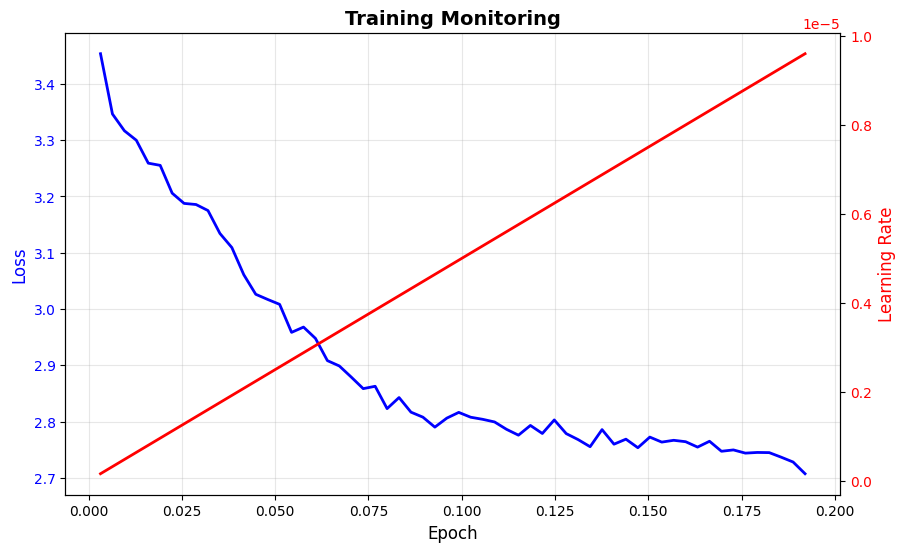

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', color='blue', fontsize=12)
ax1.plot(state["epoch"], state["loss"], color='blue', linewidth=2, label='Loss')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='red', fontsize=12)
ax2.plot(state["epoch"], state["learning_rate"], color='red', linewidth=2, label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Training Monitoring', fontsize=14, fontweight='bold')
plt.show()

# Test the Gallica, French literacy-trained model

In [3]:
final_path = "./gallica_tinyllama_bf16"
model = AutoModelForCausalLM.from_pretrained(
    final_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)
tokenizer = AutoTokenizer.from_pretrained(final_path)

In [ ]:
prompt = "K. ouvrit la porte. "

for i in range(10):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1000,
            temperature=0.8,
            top_p=0.9,
            do_sample=True,
            repetition_penalty=1.1
        )
    
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"== generation {i+1} ==")
    print(generated)
    print("\n")

== generation 0 ==
K. ouvrit la porte. 
Au premier coup de l'aiguille, on entra dans la chambre du prêtre. 
Il était entré dans l'église au moment où l'écho sifflait les derniers vers du chant qu'il chantait : « Nous ferons un service à Dieu... » Le silence était si complet que personne ne put oublier ce choc, si étrange et si douloureux. 
Les cris de fous-dieu, la crise de mort, la révélation du purgatoire. C'était la grande catastrophe. Et le cimetière avait déjà besoin d'un médecin pour se faire amener enfin à l'intérieur. 
Et puis, le malade, qui avait cru mourir, devint un pauvre homme ! 
 
C'est ce qu'on appelle une vie, parce qu'à certains moments de notre existence nous sommes le même homme, sans que jamais rien n'en change, ni la raison, ni l'esprit, ni la physionomie. Il suffit, pour être homme, de vivre longtemps; mais il faut aussi bien vivre heureusement, car il est rare qu'une vie soit plus longue que deux jours ; et quand elle se termine comme celle du malade, elle a été

# Test the final, Kafka fine-tuned model

In [3]:
final_path = "./kafka_tinyllama_bf16"
model = AutoModelForCausalLM.from_pretrained(
    final_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)
tokenizer = AutoTokenizer.from_pretrained(final_path)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [ ]:
prompt = "K. ouvrit la porte. "

for i in range(10):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1000,
            temperature=0.8,
            top_p=0.9,
            do_sample=True,
            repetition_penalty=1.1
        )
    
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"== generation {i+1} ==")
    print(generated)
    print("\n")

== generation 0 ==
K. ouvrit la porte. 
A peine eut-elle le temps d'examiner ses pieds que deux balles furent tirées de derrière, à un demi-mille de distance, et s'écoulaient vers elle. 
Cependant, l'arme était dans la main et l'objet des balles dans les yeux. 
La foule, dans les premières minutes de la guerre, se fit une partie de ce qui se passait au front. 
Elle s'occupa de détruire ou de sauver les blessés et de procurer du pain et de l'eau pour ceux qui souffraient. 
Sans être désarmée, les hommes de l'avant-garde devaient faire vivre et armer tout le reste de l'armée ; 
il y avait des hommes dont les cheveux étaient couverts de sang, quoique les blessures les frappassent moins souvent de mort. 
Les officiers étaient toujours armés de pistolets. 
Lorsqu'une femme ou un enfant arrivait sur la route, elle ne pouvait pas l'emporter. 
On l'accompagnait si nécessairement qu'on lui permettait de l'aller à sa façon et de l'y porter comme elle l'avait déjà fait. 
Il en est ainsi, même aux